Following tutorial from http://soft-matter.github.io/trackpy/v0.6.1/tutorial/custom-feature-detection.html

-CM

### Libraries

In [84]:
%matplotlib inline

import numpy as np
import pandas as pd
import pims
import trackpy as tp
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('figure', figsize=(10,6))
mpl.rc('image', cmap='gray')

datapath = './HEK/sequence'
prefix = 'test_'

### Image preprocessing

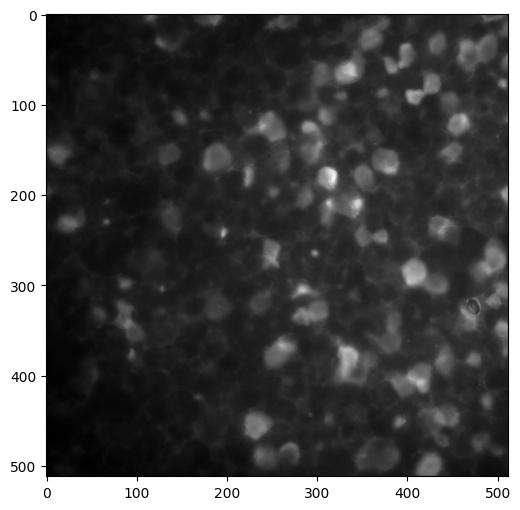

In [85]:
file_list = os.path.join(datapath, prefix + '*.tif')

id_example = 30
rawframes = pims.open(file_list)
plt.imshow(rawframes[id_example]);

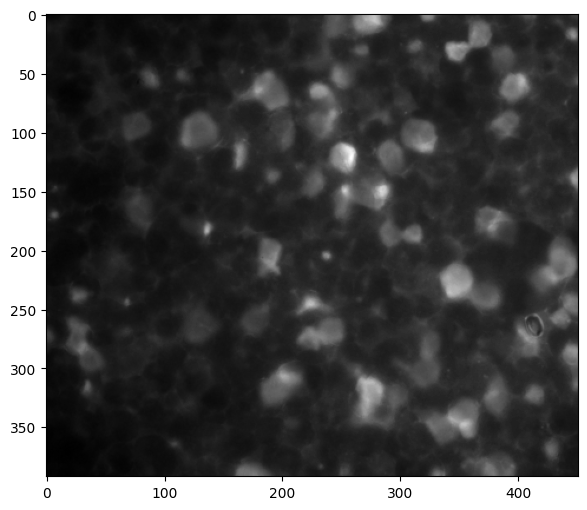

In [86]:
@pims.pipeline
def crop(img):
    """Crop the image to select the region of interest
    """
    # Crop out the dark regions at the edges, except at the right
    x_min = 60
    x_max = -1 # must be negative
    y_min = 60
    y_max = -60 # must be negative
    return img[y_min:y_max, x_min:x_max]

rawframes = crop(pims.open(file_list))
plt.imshow(rawframes[id_example]);

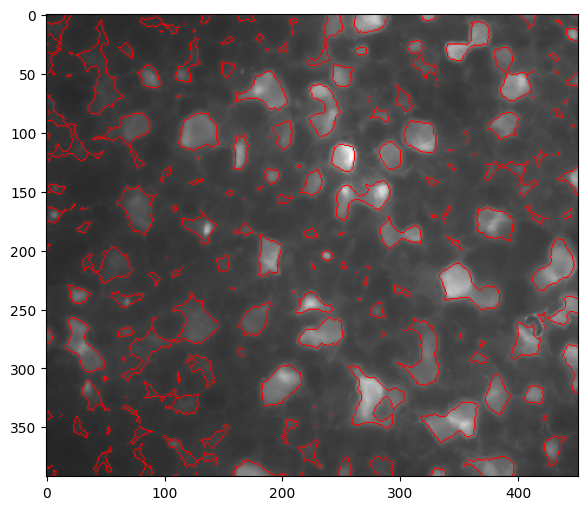

In [87]:
from scipy import ndimage
from skimage import (morphology, util, filters, segmentation)

@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """

    # Crop the pictures as for raw images.
    img = crop(img)

    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img, 101)
    idx = img > adaptive_thresh
    idx2 = img <= adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)

    return util.img_as_int(img)

frames = preprocess_foam(pims.open(file_list))
# plt.imshow(frames[id_example]);
# plt.show()
plt.imshow(segmentation.mark_boundaries(rawframes[id_example], frames[id_example], color=(1,0,0)));
plt.show()

### Custom Feature Detection

Found 205 features


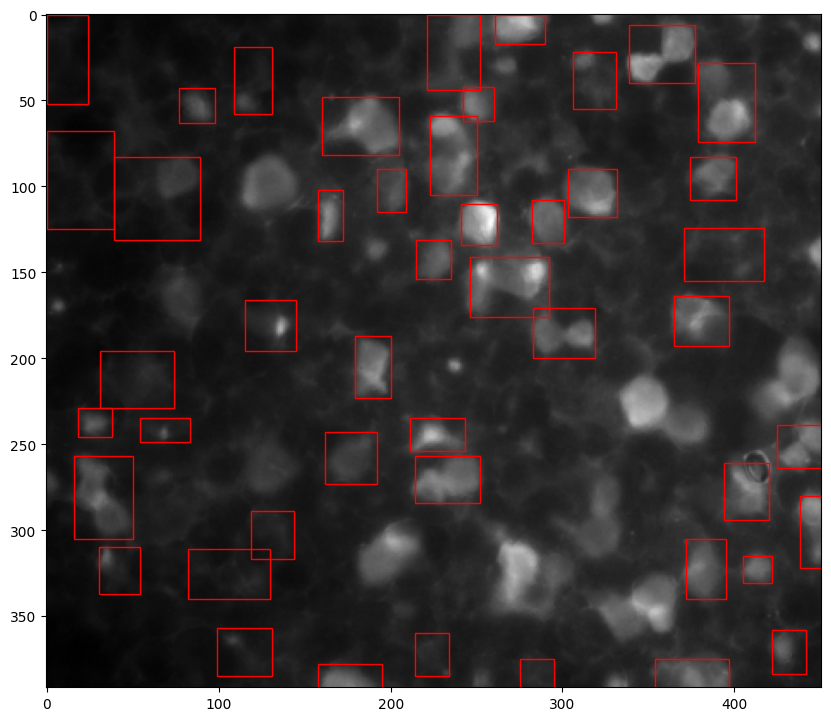

In [88]:
import skimage
import matplotlib.patches as mpatches

img_example = frames[id_example]
rawimg_example = rawframes[id_example]

def filter_out_regions(regions):
    for num, region in reversed(list(enumerate(regions))):
        if region.area < 200 or region.area > 800:
            regions.pop(num)
            continue
        
        # Everywhere, skip small and large areas
        if region.area < 200 or region.area > 800:
            regions.pop(num)
            continue
        # Only black areaas
        if region.mean_intensity > 1:
            regions.pop(num)
            continue
        # # On the top, skip small area with a second threshold
        # if region.centroid[0] < 260 and region.area < 80:
        #     regions.pop(num)
        #     continue
    return regions

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
# ax.imshow(img_example)
ax.imshow(rawimg_example)
regions = filter_out_regions(skimage.measure.regionprops(label_image, intensity_image=img_example))

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

Index(['frame', 'x', 'y'], dtype='object')


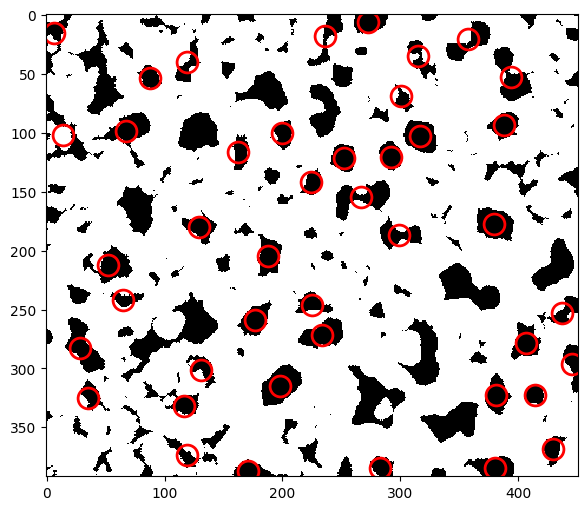

In [89]:
dict_features = {'x': [],
                 'y': [],
                 'frame': [],
                 }
features = pd.DataFrame()
white = 255
for num, img in enumerate(frames):
    label_image = skimage.measure.label(img, background=white)
    regions = filter_out_regions(skimage.measure.regionprops(label_image, intensity_image=img))
    for region in regions:
        # Store features which survived to the criterions
        # features = features.append([{'y': region.centroid[0],
        #                   'x': region.centroid[1],
        #                   'frame': num,
        #                   },])
        # dict_features.append([{'y': region.centroid[0],
        #                   'x': region.centroid[1],
        #                   'frame': num,
        #                   },])
        dict_features['y'].append(region.centroid[0])
        dict_features['x'].append(region.centroid[1])
        dict_features['frame'].append(num)

features = pd.DataFrame.from_records(dict_features)
print(features.columns)

tp.annotate(features[features.frame==(id_example+1)], img_example);

### Particle Tracking

Frame 103: 43 trajectories present.


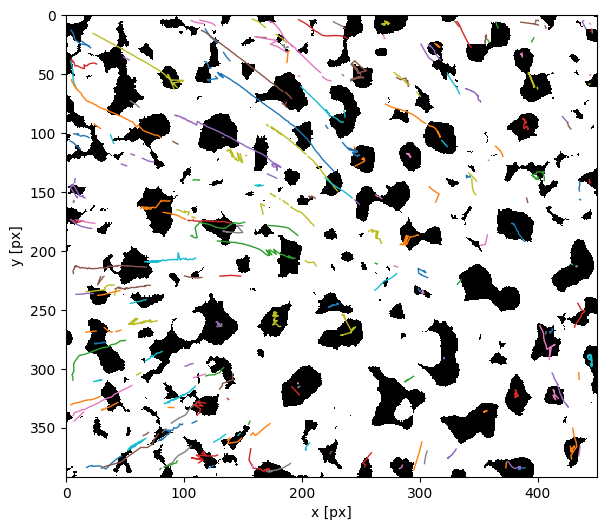

In [126]:
search_range = 11
t = tp.link_df(features, search_range, memory=5)
tp.plot_traj(t, superimpose=img_example);

unstacked = t.set_index(['frame', 'particle']).unstack()
# print(unstacked)

### Velocity Field

#### Step 1: calculation

In [110]:
col_names = ['dx', 'dy', 'x', 'y', 'frame', 'particle']
# Creating an empty dataframe to store results
data = pd.DataFrame(np.zeros(shape=(1,6), dtype=np.int64), columns=col_names)

for item in set(t.particle):
    sub = t[t.particle==item]
    if sub.shape[0]<=2:
        # Cases in which particle only has 1 or 2 rows of data
        pass
    else:
        # print('Deriving velocities for particle: {:}'.format(item))
        dvx = pd.DataFrame(np.gradient(sub.x), columns=['dx'])
        dvy = pd.DataFrame(np.gradient(sub.y), columns=['dy'])

        new_df = pd.concat((dvx, dvy, sub.x.reset_index(drop=True), sub.y.reset_index(drop=True),
                           sub.frame.reset_index(drop=True), sub.particle.reset_index(drop=True)),
                           axis=1, names=col_names, sort=False)
        data = pd.concat((data, new_df), axis=0)

# This is to get rid of the first 'np.zeros' row and to reset indices
data = data.reset_index(drop=True)
data = data.drop(0)
data = data.reset_index(drop=True)

#### Step 2: rendering

(-0.5, 450.5, 391.5, -0.5)

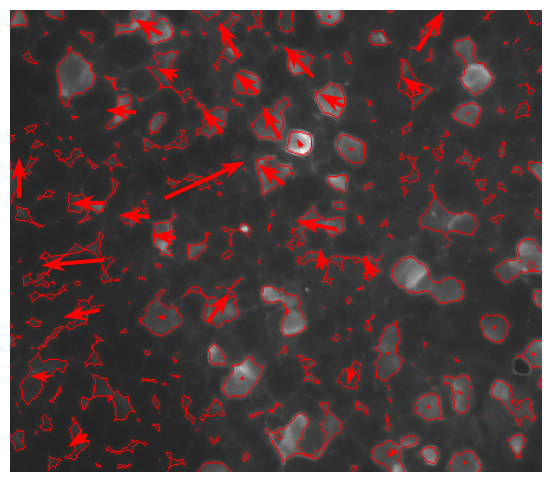

In [125]:
from matplotlib.pyplot import quiver

i = 100
d = data[data.frame == i]
# print(d)
# plt.imshow(rawframes[i])
plt.imshow(segmentation.mark_boundaries(rawframes[i], frames[i], color=(1,0,0)));
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red', scale=10)
plt.axis('off')